In [1]:
# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')
# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
folium installed...
folium imported...


In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [45]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'UYXY4PRITZONGXUJNE5WHZDO132CIAOABGIXLWH3KKSCODYZ' # your Foursquare ID
    CLIENT_SECRET = 'J00XHEBQIWB5FZC4UFLRUCCTLCRLO21IGC0UV4ISGIYEAKDD' # your Foursquare Secret
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [46]:
def get_venue_details(venue_id):
        
     CLIENT_ID = 'Y2MQTFDXRP25NUSFS4XT5EPM3RWHVVDXQURS4GARWWERRBP0' # your Foursquare ID
     CLIENT_SECRET = 'HLGAWVJ43MCVLWTTPFXNLVVR1PDT3FEXPGFOSNUJ01F2FSKV' # your Foursquare Secret
     VERSION = '20190605' # Foursquare API version
    
     #url to fetch data from foursquare api
     url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
             venue_id,
             CLIENT_ID, 
             CLIENT_SECRET, 
             VERSION)
    
     # get all the data
     results = requests.get(url).json()
     venue_data=results['response']['venue']
     venue_details=[]
     try:
         venue_id=venue_data['id']
         venue_name=venue_data['name']
         venue_likes=venue_data['likes']['count']
         venue_rating=venue_data['rating']
         venue_tips=venue_data['tips']['count']
         venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
     except KeyError:
         pass
        
     column_names=['ID','Name','Likes','Rating','Tips']
     df = pd.DataFrame(venue_details,columns=column_names)
     return df

In [47]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
    # all data is present in features label
features=resp['features']
    
    # define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [48]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [49]:
new_york_data.shape

(306, 4)

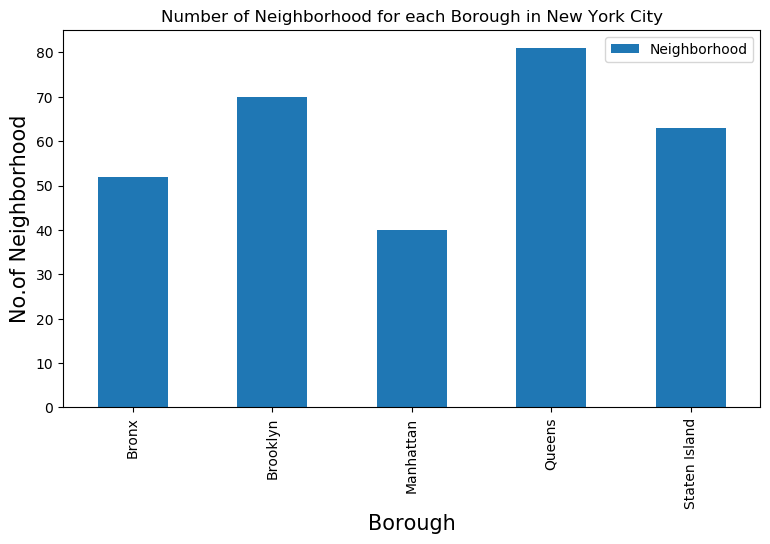

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [51]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude, Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [52]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [53]:
indian_rest_ny.shape


(147, 4)

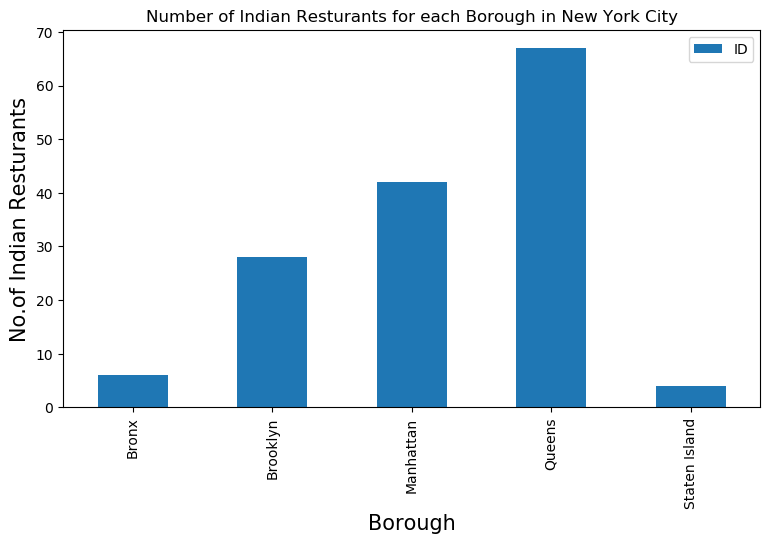

In [54]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

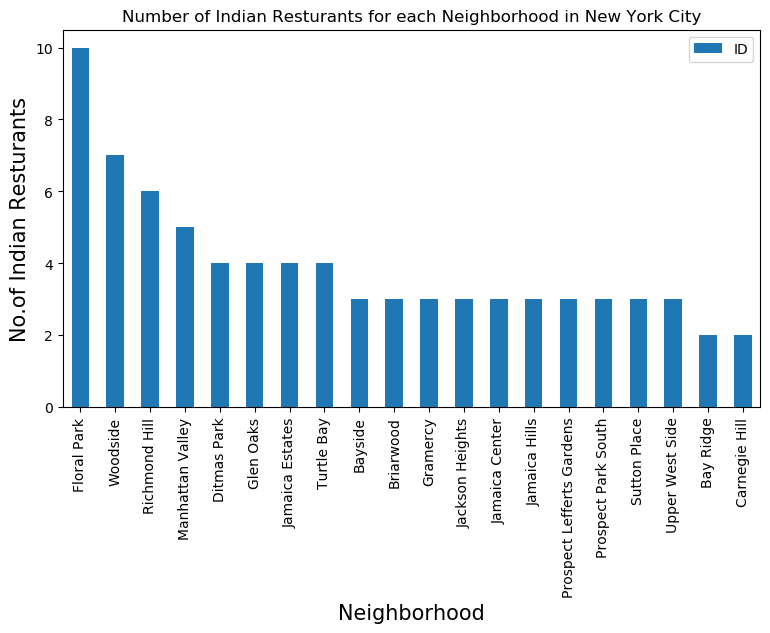

In [55]:
%matplotlib inline
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [56]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
100,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
103,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
104,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
105,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
106,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
107,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
108,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [57]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

In [58]:
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
      
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 572d7c21498e098658a0edd7
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
No data available for id= 5401515e498e60d0fe0abe3b
No data available for id= 4c953a7672dd224bd8d1a191
No data available for id= 55d68c1b498ecf05fa196fe1
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
No data available for id= 4f44d0f619836ed00196b6a9
No data available for id= 4b8d5734f964a520b1f532e3
No data available for id= 4c66f1ac8e9120a1b266d964
No data available for id= 4dc0aaedae606fe8b71c226b
No data available for id= 4c2e8df2213c2d7f94742f5d


In [59]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [60]:
indian_rest_stats_ny.shape

(147, 7)

In [61]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                                 88
Rating                               9.1
Tips                                  25
Name: 79, dtype: object

In [62]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [63]:

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
62,Sunnyside,9.100000
6,Blissville,9.100000
66,Tribeca,9.000000
12,Civic Center,9.000000
0,Astoria,8.900000
44,Murray Hill,8.800000
42,Midtown,8.800000
72,West Village,8.750000
29,Gramercy,8.733333
59,South Side,8.700000


In [64]:

ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [65]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.247619
4,Staten Island,7.900000
1,Brooklyn,7.721429
0,Bronx,6.916667
3,Queens,6.371642


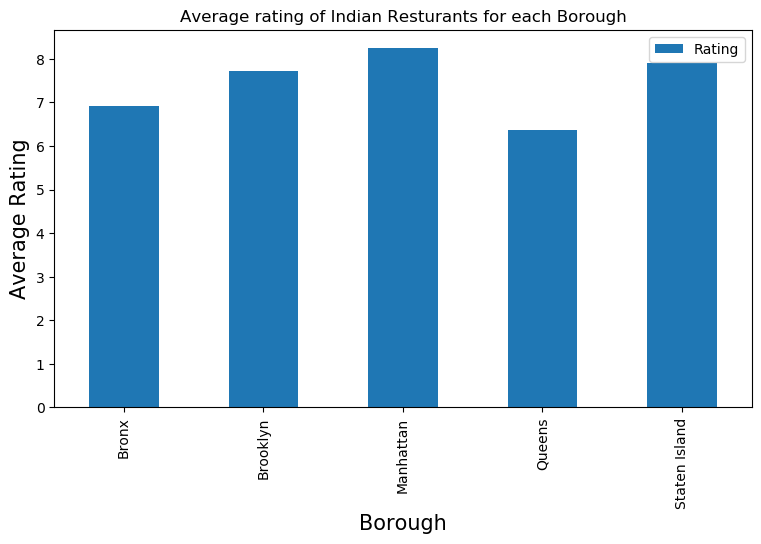

In [66]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [67]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [68]:

ny_neighborhood_stats.shape

(35, 2)

In [69]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [70]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [71]:

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.900000
1,Queens,Blissville,40.737251,-73.932442,9.100000
2,Manhattan,Carnegie Hill,40.782683,-73.953256,8.150000
3,Manhattan,Central Harlem,40.815976,-73.943211,8.100000
4,Manhattan,Chelsea,40.744035,-74.003116,8.700000
5,Staten Island,Chelsea,40.594726,-74.189560,8.700000
6,Manhattan,Civic Center,40.715229,-74.005415,9.000000
7,Brooklyn,Clinton Hill,40.693229,-73.967843,8.350000
8,Brooklyn,East Flatbush,40.641718,-73.936103,8.300000
9,Queens,Elmhurst,40.744049,-73.881656,8.600000


In [72]:

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [79]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [80]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [81]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)